# Setting up depedencies

In [1]:
%load_ext rpy2.ipython

In [2]:
import sys 
import os
import math
import datetime
import os
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
import numpy as np
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("src"))
import analysis
reload(analysis)

/home/adfaure/Projects/ptask-eval/analysis


<module 'analysis' from '/home/adfaure/Projects/ptask-eval/analysis/src/analysis.py'>

In [3]:
master_host="10.158.20.3"
server="10.158.20.2"
client="10.158.24.2"

profile=  "../experiments/simgrid/data/test.json"
hostfile= "../experiments/simgrid/hostfiles/smpi_hostfile"
csv_path = "../experiments/simgrid/data"


In [4]:
import re
string = '[10.158.20.3:simulation:(1) 312.000000] [mwe/INFO] Parallel task finished'
m = re.match(r'\[.* ([0-9\.]+)\] \[mwe/INFO\] Parallel task finished', string)
print(m)
print(m.group(1))

<re.Match object; span=(0, 73), match='[10.158.20.3:simulation:(1) 312.000000] [mwe/INFO>
312.000000


## tcpakali is an actor

In [5]:
def get_predicted_time(output):
    t = list(filter(lambda x: x.endswith(" Parallel task finished"),  output.splitlines()))[0]
    m = re.match(r'\[.* ([0-9\.]+)\] \[mwe/INFO\] Parallel task finished', t)
    return m.group(1)


# Prepare dataframe to get the data
df = pd.DataFrame(columns=['source', 'time', 'pattern'])

In [6]:

profile =  "../experiments/simgrid/data/paje_nbhost-32_nbrank-256_dims-80000.0_subdivisions-50/profile_old.json"

p = subprocess.run(" ".join(["../experiments/simgrid/b/main", "../experiments/simgrid/platforms/parasilo.xml",
    master_host,
    "-p", profile,
    "-H", hostfile, "> {}/no_interference_tcpkali_actor.csv".format(csv_path) ]), stdout = subprocess.PIPE, stderr = subprocess.PIPE, shell = True)

time = float(get_predicted_time(p.stderr.decode()))
new_row = {'source': 'Ptask (tcpkali is ptask)', 'time': time, 'kind': 'simulation', 'pattern': 'No interference'}
df = df.append(new_row, ignore_index=True)


for (idle, inter) in [(10, 10), (30, 30), (10, 20), (20, 10), (0, 10)]:
    process = subprocess.run(" ".join(["../experiments/simgrid/b/main",
      "interference",
      "../experiments/simgrid/platforms/parasilo.xml",
      master_host,
      "-H", hostfile,
      "-s", server, "-c" ,client,
      "-p", profile, "-t", str(inter), "-d", str(idle),
      " > {}/{}inter_{}idle_tcpkali_actor.csv".format(csv_path ,str(inter), str(idle))]), shell = True, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    time = float(get_predicted_time(process.stderr.decode()))
    new_row = {'source': 'Ptask (tcpkali is s4u::Actor)', 'time': time, 'kind': 'simulation', 'pattern': '{}inter_{}idle'.format(inter, idle)}
    df = df.append(new_row, ignore_index=True)


IndexError: list index out of range

## tcpkali is a ptask

In [7]:
profile =  "../experiments/simgrid/data/paje_nbhost-32_nbrank-256_dims-80000.0_subdivisions-50/profile_old.json"

p = subprocess.run(" ".join(["../experiments/simgrid/b/main", "../experiments/simgrid/platforms/parasilo.xml",
    master_host,
    "-p", profile,
    "-H", hostfile, "> {}/no_interference_tcpkali_ptask.csv".format(csv_path) ]), stdout = subprocess.PIPE, stderr = subprocess.PIPE, shell = True)

time = float(get_predicted_time(p.stderr.decode()))
new_row = {'source': 'Ptask (tcpkali is s4u::Actor)', 'time': time, 'kind': 'simulation', 'pattern': 'No interference'}
df = df.append(new_row, ignore_index=True)


for (idle, inter) in [(10, 10), (30, 30), (10, 20), (20, 10), (0, 10), (100, 100)]:
    process = subprocess.run(" ".join(["../experiments/simgrid/b/main",
      "interference",
      "../experiments/simgrid/platforms/parasilo.xml",
      master_host,
      "-H", hostfile,
      "-s", server, "-c" ,client, "--ptask",
      "-p", profile, "-t", str(inter), "-d", str(idle),
      " > {}/{}inter_{}idle_tcpkali_ptask.csv".format(csv_path ,str(inter), str(idle))]), shell = True, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    time = float(get_predicted_time(process.stderr.decode()))
    new_row = {'source': 'Ptask (tcpkali is s4u::ptask)', 'time': time, 'kind': 'simulation', 'pattern': '{}inter_{}idle'.format(inter, idle)}
    df = df.append(new_row, ignore_index=True)

print(df)
df.to_csv("../experiments/comparison.csv", index = False)

IndexError: list index out of range

## PDGEMM is cut in several ptasks

```python
profile =  "../experiments/simgrid/data/paje_nbhost-32_nbrank-256_dims-80000.0_subdivisions-50/aggregated_16.json"

p = subprocess.run(" ".join(["../experiments/simgrid/b/main", "../experiments/simgrid/platforms/parasilo.xml",
    master_host,
    "-p", profile,
    "-H", hostfile, "> {}/no_interference_tcpkali_actor_sequence.csv".format(csv_path) ]), stdout = subprocess.PIPE, stderr = subprocess.PIPE, shell = True)

print(p.stderr.decode())

for (idle, inter) in [(10, 10), (30, 30), (10, 20), (20, 10), (0, 300)]:
    process = subprocess.run(" ".join(["../experiments/simgrid/b/main",
      "interference",
      "../experiments/simgrid/platforms/parasilo.xml",
      master_host,
      "-H", hostfile,
      "-s", server, "-c" ,client,
      "-p", profile, "-t", str(inter), "-d", str(idle),
      " > {}/{}inter_{}idle_tcpkali_actor_sequence.csv".format(csv_path ,str(inter), str(idle))]), shell = True, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
```

Print the runtimes for each instance of each configuration.

/nix/store/8wiagpf61dbcpwizdazy3byq6h8qb2xk-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/nix/store/8wiagpf61dbcpwizdazy3byq6h8qb2xk-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/nix/store/8wiagpf61dbcpwizdazy3byq6h8qb2xk-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/nix/store/8wiagpf61dbcpwizdazy3byq6h8qb2xk-python3-3.7.3-env/lib/python3.7/site-packa

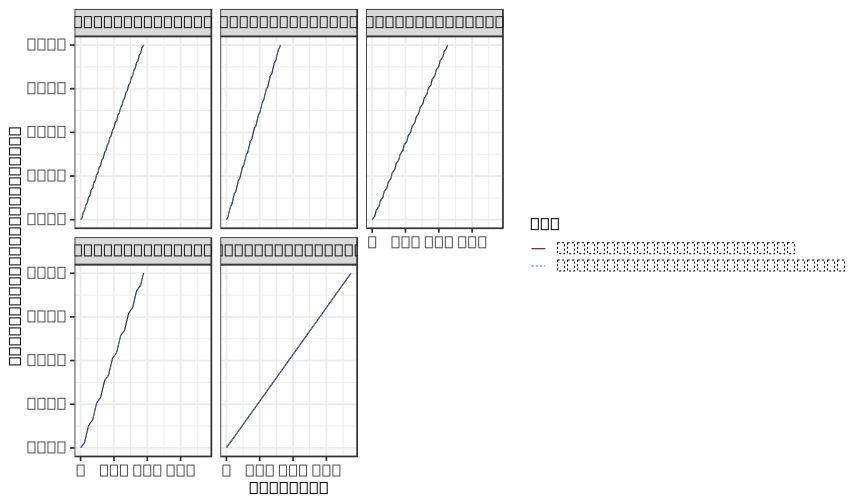

In [8]:
%%R -w 12 -h 7 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

theme_set(theme_bw())

ptask_tcpkali_actor = read_csv("../experiments/simgrid/data/no_interference_tcpkali_actor.csv") %>% mutate(noise = "No network interference") %>%
    bind_rows(read_csv("../experiments/simgrid/data/10inter_0idle_tcpkali_actor.csv")  %>% mutate(noise = "Constant interference")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/10inter_10idle_tcpkali_actor.csv") %>% mutate(noise = "10s intereference / 10s idle")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/10inter_20idle_tcpkali_actor.csv") %>% mutate(noise = "10s intereference / 20s idle")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/20inter_10idle_tcpkali_actor.csv") %>% mutate(noise = "20s intereference / 10s idle")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/30inter_30idle_tcpkali_actor.csv") %>% mutate(noise = "30s intereference / 30s idle")) %>% 
    mutate(src = "Ptask (tcpkali is s4u::actor)")

ptask_tcpkali_ptask = read_csv("../experiments/simgrid/data/no_interference_tcpkali_ptask.csv") %>% mutate(noise = "No network interference") %>%
    bind_rows(read_csv("../experiments/simgrid/data/10inter_0idle_tcpkali_ptask.csv")  %>% mutate(noise = "Constant interference")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/10inter_10idle_tcpkali_ptask.csv") %>% mutate(noise = "10s intereference / 10s idle")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/10inter_20idle_tcpkali_ptask.csv") %>% mutate(noise = "10s intereference / 20s idle")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/20inter_10idle_tcpkali_ptask.csv") %>% mutate(noise = "20s intereference / 10s idle")) %>%
    bind_rows(read_csv("../experiments/simgrid/data/30inter_30idle_tcpkali_ptask.csv") %>% mutate(noise = "30s intereference / 30s idle")) %>% 

    mutate(src = "Ptask (tcpkali is ptask)")

# ptask_tcpkali_actor_seq = read_csv("../experiments/simgrid/data/no_interference_tcpkali_actor_sequence.csv") %>% mutate(noise = "No network interference") %>%
#    bind_rows(read_csv("../experiments/simgrid/data/10inter_0idle_tcpkali_actor_sequence.csv")  %>% mutate(noise = "Constant interference")) %>%
#    bind_rows(read_csv("../experiments/simgrid/data/10inter_10idle_tcpkali_actor_sequence.csv") %>% mutate(noise = "10s intereference / 10s idle")) %>%
#    bind_rows(read_csv("../experiments/simgrid/data/10inter_20idle_tcpkali_actor_sequence.csv") %>% mutate(noise = "10s intereference / 20s idle")) %>%
#    bind_rows(read_csv("../experiments/simgrid/data/20inter_10idle_tcpkali_actor_sequence.csv") %>% mutate(noise = "20s intereference / 10s idle")) %>%
#    bind_rows(read_csv("../experiments/simgrid/data/30inter_30idle_tcpkali_actor_sequence.csv") %>% mutate(noise = "30s intereference / 30s idle")) %>% 
#    mutate(src = "Ptask Sequence (tcpkali is s4u::actor)")

    
ptask = bind_rows(ptask_tcpkali_actor, ptask_tcpkali_ptask) %>% mutate(kind = "Ptask")
# ptask = ptask_tcpkali_actor_seq 


ptask %>%
    ggplot(aes(y = progress, x = time, colour = noise)) +
    geom_line() + facet_wrap(~src) + scale_color_viridis_d(end = 1) + theme_bw(base_size = 18) + ggsave("/tmp/lol.png")
    
ptask %>%
    ggplot(aes(y = progress, x = time, colour = src, linetype = src)) +
    ylab("Application progress (%)") + xlab("Time (s)") +
    geom_line() + facet_wrap(~noise) + scale_color_viridis_d(end = 0.5) +
    theme_bw(base_size = 18) + 
    ggsave("/tmp/comparison.png")
    

In [10]:
%%R  -w 12 -h 7 --units in

# Levels to choose facet cells order
levels = c("No network interference", 
           "10s intereference / 20s idle",
           "10s intereference / 10s idle",  
           "30s intereference / 30s idle",
           "20s intereference / 10s idle", 
           "Constant interference")

ibcast = read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_kali_ibcast/256c_no_kali_ibcast/2165277e/mpi_progress.csv") %>%
                  mutate(noise = "No network interference", src = "G5K - Ibcast") %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_periods_ibcast/256c_noper_ibcast/62c5c9c1/mpi_progress.csv") %>%
                  mutate(noise = "Constant interference", src = "G5K - Ibcast") ) %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10s_ibcast/256c_per10s_ibcast/daa39f98/mpi_progress.csv") %>%
                  mutate(noise = "10s intereference / 10s idle", src = "G5K - Ibcast") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods30s_ibcast/256c_periods30s_ibcast/7c9c89d2/mpi_progress.csv") %>%
                  mutate(noise = "30s intereference / 30s idle", src = "G5K - Ibcast") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10sidle20sinter_ibcast/256c_per10sidle20sinter_ibcast/1ffcca2a/mpi_progress.csv") %>%
                  mutate(noise = "20s intereference / 10s idle", src = "G5K - Ibcast") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods20sidle10sinter_ibcast/256c_per20sidle10sinter_ibcast/19d1b5aa/mpi_progress.csv") %>%
                  mutate(noise = "10s intereference / 20s idle", src = "G5K - Ibcast") )

bcast = read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_kali_bcast/256c_no_kali_bcast/023bd52f/mpi_progress.csv") %>%
                  mutate(noise = "No network interference", src = "G5K - Bcast") %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_no_periods_bcast/256c_noper_bcast/1af88686/mpi_progress.csv") %>%
                  mutate(noise = "Constant interference", src = "G5K - Bcast") ) %>% 
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10s_bcast/256c_per10s_bcast/4f5cd068/mpi_progress.csv") %>%
                  mutate(noise = "10s intereference / 10s idle", src = "G5K - Bcast") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods30s_bcast/256c_periods30s_bcast/6dcb0830/mpi_progress.csv") %>%
                  mutate(noise = "30s intereference / 30s idle", src = "G5K - Bcast") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods10sidle20sinter_bcast/256c_per10sidle20sinter_bcast/49208eab/mpi_progress.csv") %>%
                  mutate(noise = "20s intereference / 10s idle", src = "G5K - Bcast") ) %>%
        bind_rows( read_csv("../experiments/g5k/data/parasilo/parasilo_march/50s_periods20sidle10sinter_bcast/256c_per20sidle10sinter_bcast/07a7e1af/mpi_progress.csv") %>%
                  mutate(noise = "10s intereference / 20s idle", src = "G5K - Bcast") )

real = bind_rows(ibcast, bcast) %>% mutate(progress = loop / max(loop), time = max_comp_end, kind = "Real") %>% select(progress, time, src, noise, kind)

/nix/store/8wiagpf61dbcpwizdazy3byq6h8qb2xk-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  X1 = col_double(),
  loop = col_double(),
  max_bcast_begin = col_double(),
  min_bcast_begin = col_double(),
  max_bcast_end = col_double(),
  min_bcast_end = col_double(),
  max_comp_begins = col_double(),
  min_comp_begins = col_double(),
  max_comp_end = col_double(),
  min_comp_end = col_double()
)

  warnings.warn(x, RRuntimeWarning)


Merge everything togethers

In [12]:
%%R  -w 12 -h 7 --units in

real_and_sim = bind_rows(real, list(ptask)) %>%  mutate( noise = factor(noise, levels=levels))

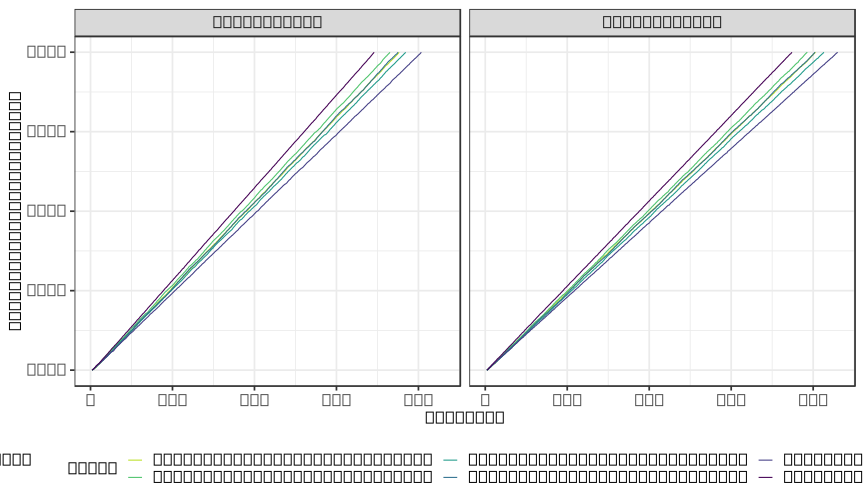

In [13]:
%%R  -w 12 -h 7 --units in

    
real %>%
    ggplot(aes(y = progress, x = time, colour = noise, linetype = kind)) +
    ylab("Application progress (%)") + xlab("Time (s)") +
    geom_line() + facet_wrap(~src) + scale_color_viridis_d(end = 0.9, direction = -1) + theme_bw(base_size = 18) +
    theme(legend.position = "bottom")
    # ggsave("/home/adfaure/Projects/Thesis/img/pdgemm_ptask_comparison_grouped.pdf")


In [26]:
%%R  -w 14 -h 8 --units in

real_and_sim %>%
    ggplot(aes(y = progress, x = time, colour = src, linetype = kind)) +
    ylab("Application progress (%)") + xlab("Time (s)") +
    geom_line() + facet_wrap(~noise) + scale_color_viridis_d(end = 0.9, direction = -1) + theme_bw(base_size = 18) +
    theme(legend.position = "bottom")



Error in eval(lhs, parent, parent) : object 'real_and_sim' not found
